In [1]:
import pickle
import torch
import copy
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import torchvision.models as models
import torchsummary

from skimage import io
from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path
from torchvision import transforms
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from torch.utils.data import Dataset, DataLoader
from matplotlib import colors, pyplot as plt
%matplotlib inline

train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
torch.cuda.is_available()

CUDA is available!  Training on GPU ...


True

In [2]:
DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224
DEVICE = torch.device("cuda")
EPOCHS=30
BATCH_SIZE=64
N_FOLDS = 2

SEED = 69
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform_list = []
        transform_list.append(transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)))
        if self.mode != 'test':            
            transform_list.append(transforms.RandomHorizontalFlip())
            transform_list.append(transforms.RandomRotation(15))
        transform_list.append(transforms.ToTensor())
        transform_list.append(transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]))
        
        transform = transforms.Compose(transform_list)
        x = self.load_sample(self.files[index])
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

In [4]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))
train_val_labels = [path.parent.name for path in train_val_files]

In [5]:
def create_dct_path_labels(train_val_files, train_val_labels):
    dct_simpsons = {}
    for label_i in np.unique(train_val_labels).tolist():
        dct_simpsons[label_i] = []

    for path_i, label_i in zip(train_val_files, train_val_labels):
        dct_simpsons[label_i].append(path_i)

    return dct_simpsons

In [6]:
dct_path_train = create_dct_path_labels(train_val_files, train_val_labels)
print(len(train_val_files))

for person in dct_path_train:
    if len(dct_path_train[person]) < 100:
        dct_path_train[person] = dct_path_train[person] * (100 // len(dct_path_train[person]))
        dct_path_train[person].extend(dct_path_train[person][:100 - len(dct_path_train[person])])
        
train_val_files = []
for person in dct_path_train:
    train_val_files.extend(dct_path_train[person])
print(len(train_val_files))

train_val_labels = [path.parent.name for path in train_val_files]
train_val_dataset = SimpsonsDataset(train_val_files, mode='val')

20933
21887


In [7]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
        criterion = nn.CrossEntropyLoss()
        scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=5, gamma=0.1)
        
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            scheduler.step()                
    return history

def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [8]:
n_classes = len(np.unique(train_val_labels))
clf = models.resnet18(pretrained=True)

for param in clf.parameters():
    param.requires_grad = False
    
clf.fc = nn.Linear(in_features=clf.fc.in_features, out_features=n_classes)
clf = clf.to('cuda')
torchsummary.summary(clf.cuda(), (3, RESCALE_SIZE, RESCALE_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [9]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE)
submit = pd.DataFrame(columns=['Id'])


FOLD 1


epoch:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]

loss 2.4294599394121565


epoch:   3%|██▌                                                                        | 1/30 [01:42<49:32, 102.51s/it]


Epoch 001 train_loss: 2.4295     val_loss 1.3821 train_acc 0.4343 val_acc 0.7064
loss 0.8392718569442383


epoch:   7%|█████                                                                      | 2/30 [03:22<47:28, 101.72s/it]


Epoch 002 train_loss: 0.8393     val_loss 0.5856 train_acc 0.7930 val_acc 0.8477
loss 0.4372842376621922


epoch:  10%|███████▌                                                                   | 3/30 [05:03<45:38, 101.41s/it]


Epoch 003 train_loss: 0.4373     val_loss 0.4551 train_acc 0.8850 val_acc 0.8758
loss 0.2658645382427945


epoch:  13%|██████████                                                                 | 4/30 [06:45<44:07, 101.83s/it]


Epoch 004 train_loss: 0.2659     val_loss 0.3237 train_acc 0.9292 val_acc 0.9174
loss 0.20451155109912292


epoch:  17%|████████████▌                                                              | 5/30 [08:25<42:10, 101.20s/it]


Epoch 005 train_loss: 0.2045     val_loss 0.2600 train_acc 0.9486 val_acc 0.9361
loss 0.10280626632472688


epoch:  20%|███████████████                                                            | 6/30 [10:06<40:27, 101.13s/it]


Epoch 006 train_loss: 0.1028     val_loss 0.2339 train_acc 0.9762 val_acc 0.9444
loss 0.08592499410276558


epoch:  23%|█████████████████▌                                                         | 7/30 [11:47<38:41, 100.92s/it]


Epoch 007 train_loss: 0.0859     val_loss 0.2299 train_acc 0.9815 val_acc 0.9461
loss 0.08259343499077594


epoch:  27%|████████████████████                                                       | 8/30 [13:28<37:04, 101.13s/it]


Epoch 008 train_loss: 0.0826     val_loss 0.2345 train_acc 0.9819 val_acc 0.9455
loss 0.07639159789978014


epoch:  30%|██████████████████████▌                                                    | 9/30 [15:10<35:29, 101.38s/it]


Epoch 009 train_loss: 0.0764     val_loss 0.2251 train_acc 0.9819 val_acc 0.9486
loss 0.07348283336457077


epoch:  33%|████████████████████████▋                                                 | 10/30 [16:52<33:50, 101.53s/it]


Epoch 010 train_loss: 0.0735     val_loss 0.2217 train_acc 0.9839 val_acc 0.9490
loss 0.06475421256910596


epoch:  37%|███████████████████████████▏                                              | 11/30 [18:34<32:09, 101.55s/it]


Epoch 011 train_loss: 0.0648     val_loss 0.2226 train_acc 0.9857 val_acc 0.9482
loss 0.06383695169097951


epoch:  40%|█████████████████████████████▌                                            | 12/30 [20:20<30:52, 102.92s/it]


Epoch 012 train_loss: 0.0638     val_loss 0.2215 train_acc 0.9854 val_acc 0.9485
loss 0.06262738377476788


epoch:  43%|████████████████████████████████                                          | 13/30 [22:10<29:49, 105.25s/it]


Epoch 013 train_loss: 0.0626     val_loss 0.2254 train_acc 0.9867 val_acc 0.9492
loss 0.0651461656346548


epoch:  47%|██████████████████████████████████▌                                       | 14/30 [23:57<28:08, 105.55s/it]


Epoch 014 train_loss: 0.0651     val_loss 0.2264 train_acc 0.9854 val_acc 0.9483
loss 0.05879377917855359


epoch:  50%|█████████████████████████████████████                                     | 15/30 [25:49<26:56, 107.74s/it]


Epoch 015 train_loss: 0.0588     val_loss 0.2180 train_acc 0.9871 val_acc 0.9515
loss 0.05974820632336726


epoch:  53%|███████████████████████████████████████▍                                  | 16/30 [27:43<25:32, 109.46s/it]


Epoch 016 train_loss: 0.0597     val_loss 0.2179 train_acc 0.9867 val_acc 0.9517
loss 0.06124504403819945


epoch:  57%|█████████████████████████████████████████▉                                | 17/30 [29:35<23:51, 110.08s/it]


Epoch 017 train_loss: 0.0612     val_loss 0.2182 train_acc 0.9871 val_acc 0.9502
loss 0.06240722445942503


epoch:  60%|████████████████████████████████████████████▍                             | 18/30 [31:20<21:44, 108.69s/it]


Epoch 018 train_loss: 0.0624     val_loss 0.2180 train_acc 0.9866 val_acc 0.9510
loss 0.06295481410766393


epoch:  63%|██████████████████████████████████████████████▊                           | 19/30 [33:01<19:30, 106.41s/it]


Epoch 019 train_loss: 0.0630     val_loss 0.2176 train_acc 0.9868 val_acc 0.9506
loss 0.06193357853372616


epoch:  67%|█████████████████████████████████████████████████▎                        | 20/30 [34:41<17:24, 104.45s/it]


Epoch 020 train_loss: 0.0619     val_loss 0.2204 train_acc 0.9874 val_acc 0.9488
loss 0.06143746911842122


epoch:  70%|███████████████████████████████████████████████████▊                      | 21/30 [36:24<15:37, 104.14s/it]


Epoch 021 train_loss: 0.0614     val_loss 0.2216 train_acc 0.9872 val_acc 0.9499
loss 0.06118475047582618


epoch:  73%|██████████████████████████████████████████████████████▎                   | 22/30 [38:12<14:02, 105.31s/it]


Epoch 022 train_loss: 0.0612     val_loss 0.2271 train_acc 0.9866 val_acc 0.9486
loss 0.060246758581253446


epoch:  77%|████████████████████████████████████████████████████████▋                 | 23/30 [39:52<12:05, 103.67s/it]


Epoch 023 train_loss: 0.0602     val_loss 0.2213 train_acc 0.9873 val_acc 0.9509
loss 0.0612768100292569


epoch:  80%|███████████████████████████████████████████████████████████▏              | 24/30 [41:35<10:19, 103.31s/it]


Epoch 024 train_loss: 0.0613     val_loss 0.2286 train_acc 0.9867 val_acc 0.9476
loss 0.06377810041306034


epoch:  83%|█████████████████████████████████████████████████████████████▋            | 25/30 [43:14<08:30, 102.13s/it]


Epoch 025 train_loss: 0.0638     val_loss 0.2222 train_acc 0.9857 val_acc 0.9486
loss 0.061452912333438685


epoch:  87%|████████████████████████████████████████████████████████████████▏         | 26/30 [45:00<06:52, 103.17s/it]


Epoch 026 train_loss: 0.0615     val_loss 0.2180 train_acc 0.9866 val_acc 0.9494
loss 0.06279531891452544


epoch:  90%|██████████████████████████████████████████████████████████████████▌       | 27/30 [46:42<05:08, 102.95s/it]


Epoch 027 train_loss: 0.0628     val_loss 0.2239 train_acc 0.9864 val_acc 0.9497
loss 0.06040527763575885


epoch:  93%|█████████████████████████████████████████████████████████████████████     | 28/30 [48:23<03:24, 102.28s/it]


Epoch 028 train_loss: 0.0604     val_loss 0.2256 train_acc 0.9872 val_acc 0.9483
loss 0.06388124776557312


epoch:  97%|███████████████████████████████████████████████████████████████████████▌  | 29/30 [50:01<01:41, 101.01s/it]


Epoch 029 train_loss: 0.0639     val_loss 0.2202 train_acc 0.9861 val_acc 0.9503
loss 0.06465313125534161


epoch: 100%|██████████████████████████████████████████████████████████████████████████| 30/30 [51:40<00:00, 103.36s/it]


Epoch 030 train_loss: 0.0647     val_loss 0.2185 train_acc 0.9863 val_acc 0.9499


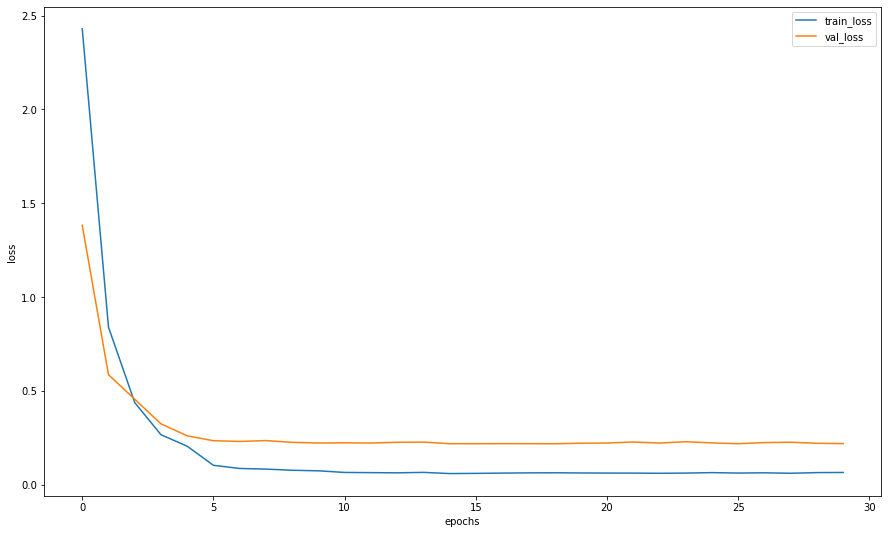

In [10]:
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

for fold, (train_idx, val_idx) in enumerate(skf.split(train_val_files, label_encoder.transform(train_val_labels))):
    print('\nFOLD', fold+1)
    val_dataset = SimpsonsDataset(np.array(train_val_files)[val_idx], mode='val')
    train_dataset = SimpsonsDataset(np.array(train_val_files)[train_idx], mode='train')
    
    clf = models.resnet18(pretrained=True)
    clf.fc = nn.Linear(in_features=clf.fc.in_features, out_features=n_classes)
    clf = clf.to('cuda')
        
    history = train(train_dataset, val_dataset, model=clf, epochs=EPOCHS, batch_size=BATCH_SIZE)
    loss, acc, val_loss, val_acc = zip(*history)
    plt.figure(figsize=(15, 9))
    plt.plot(loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()
    plt.close()
    
    probs = predict(clf, test_loader)
    preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))    
    submit[f'fold_{fold+1}'] = preds    
    break

In [11]:
torch.cuda.empty_cache()

###  Submission

In [12]:
test_filenames = [path.name for path in test_dataset.files]
submit['Id'] = test_filenames
submit['Expected'] = submit.mode(axis=1)[0]
submit[['Id', 'Expected']].to_csv('submission_resnet18_sgd_lrs5.csv', index=False)
submit.head()

,Id,fold_1,Expected
0,img0.jpg,nelson_muntz,img0.jpg
1,img1.jpg,bart_simpson,bart_simpson
2,img10.jpg,ned_flanders,img10.jpg
3,img100.jpg,chief_wiggum,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon,apu_nahasapeemapetilon
